<h1> Classifying Cinematic Shot Types with Convolutional Neural Networks

<h2> Table of Contents

1. [Setup](#setup)


2. [Data Augmentation](#dataug)                          <br>
    2.1 [Defining Input Aspect Ratio](#dataug-ar)        <br>
    2.2 [Defining Data Augmentations](#dataug-def)       <br>
    

3. [Stage 1](#stage1)                                          
    3.1 [Data Setup & Preview](#stage1-data)             <br>
    3.2 [Training](#stage1-train)                        <br>
    3.3 [Interpreting](#stage1-interpret1)               <br>
    3.4 [Fine Tuning](#stage1-finetune)                  <br>
    3.5 [Interpreting](#stage1-interpret2)               <br>


4. [Stage 2](#stage2)                                          
    4.1 [Data Setup & Preview](#stage2-data)             <br>
    4.2 [Training](#stage2-train)                        <br>
    4.3 [Interpreting](#stage2-interpret1)               <br>
    4.4 [Fine Tuning](#stage2-finetune)                  <br>
    4.5 [Interpreting](#stage2-interpret2)               <br>


5. [Stage 3](#stage3)                                          
    5.1 [Data Setup & Preview](#stage3-data)             <br>
    5.2 [Training](#stage3-train)                        <br>
    5.3 [Interpreting](#stage3-interpret1)               <br>
    5.4 [Fine Tuning](#stage3-finetune)                  <br>


6. [Interpreting the Model](#interpret)                  <br>
    6.1 [Confusion Matrix](#interpret-conf-mt)           <br>
    6.2 [Top Losses](#interpret-top-losses)              <br>

[](#)
[](#)
[](#)

##  Setup                       <a id='setup'></a>

In [8]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from pathlib import Path

In [9]:
from fastai.vision import *
from fastai.metrics import error_rate

In [10]:
path = Path('D:\\Programowanie\\AI\\shot_classifier\\DATA_SET\\extreme_wide_shot')

## Data Augmentation <a id='dataug'></a>

### Defining Input Aspect Ratio         <a id='dataug-ar'></a>

Since most films are shot in 16:9 aspect ratio, the model will take in input images that are transformed to the same aspect ratios

**Note:** input images `img_size` will be that of `(base_size, 1.7777 * base_size)`

In [11]:
base_size = 64
to_film_ar = lambda height: (height, int(height * 16/9))

In [12]:
img_size = to_film_ar(base_size)

### Defining Data Transformations    <a id='dataug-def'></a>

In [19]:
def xtra_tfms(base_size = base_size): 
    box_dim = int(base_size/4)
    #cutout_ = partial(cutout, p = .8,   n_holes = (20, 20), length = (box_dim, box_dim))
    cutout_ = partial(cutout, p = .8, n_holes = (1,1), length = (box_dim, box_dim))
    jitter_ = partial(jitter, p = 0.5,  magnitude = (0.005, 0.01))
    skew_   = partial(skew,   p = 0.5, direction = (0, 7), magnitude = 0.2)
    squish_ = partial(squish, p = 0.5, row_pct = 0.25, col_pct = 0.25)
    tilt_   = partial(tilt,   p = 0.5, direction = (0, 3))
    perp_warp_ = partial(perspective_warp, p = 0.5, magnitude = (-0.2, 0.2))
    crop_pad_  = partial(crop_pad, p = 0.5, padding_mode = 'border', row_pct = 0.1, col_pct = 0.1)
    rgb_randomize_ = partial(rgb_randomize, thresh=0.05)
    #dihedral_  = partial(dihedral, ())
    
    xtra_tfms = [jitter_(), skew_(), squish_(), perp_warp_(),
                 tilt_(), cutout_(), crop_pad_()]
    
    return xtra_tfms

In [18]:
def get_tfms(): return get_transforms(do_flip = True,
                                      flip_vert = False,
                                      max_zoom = 1.,
                                      max_lighting = 0.4,
                                      max_warp = 0.3,
                                      p_affine = 0.85,
                                      p_lighting = 0.85,
                                      xtra_tfms = xtra_tfms())

To see what these data augmentations look like, visit fastai's [docs](https://docs.fast.ai/vision.transform.html)

## Stage 1 <a id='stage1'></a>

### Data Setup & Preview <a id='stage1-data'></a>

In [20]:
bs = 64
base_size = 75

tfms = get_tfms()
img_size = to_film_ar(base_size)

img_size

NameError: name 'get_transforms' is not defined

In [ ]:
data = ImageDataBunch.from_folder(path, 'train', 'valid', size = img_size, ds_tfms = tfms, bs=bs,
                                  resize_method = ResizeMethod.SQUISH,
                                  num_workers = 0
                                 ).normalize(imagenet_stats)

In [ ]:
print(data.train_ds)
print()
print(data.valid_ds)

LabelList (5506 items)
x: ImageList
Image (3, 75, 133),Image (3, 75, 133),Image (3, 75, 133),Image (3, 75, 133),Image (3, 75, 133)
y: CategoryList
Close-Up,Close-Up,Close-Up,Close-Up,Close-Up
Path: /home/rahul/Desktop/cinema_shot_type

LabelList (600 items)
x: ImageList
Image (3, 75, 133),Image (3, 75, 133),Image (3, 75, 133),Image (3, 75, 133),Image (3, 75, 133)
y: CategoryList
Close-Up,Close-Up,Close-Up,Close-Up,Close-Up
Path: /home/rahul/Desktop/cinema_shot_type


In [1]:
data.show_batch()

NameError: name 'data' is not defined

### Training                        <a id='stage1-train'></a>

In [21]:
learn = cnn_learner(data, models.resnet50, metrics = [accuracy], pretrained=True)
learn = learn.to_fp16()

NameError: name 'cnn_learner' is not defined

In [22]:
learn.lr_find()
learn.recorder.plot()

NameError: name 'learn' is not defined

In [ ]:
learn.fit_one_cycle(8, slice(3e-3))

In [ ]:
learn.save('stage-1-1')

### Interpreting                  <a id='stage1-interpret1'></a>

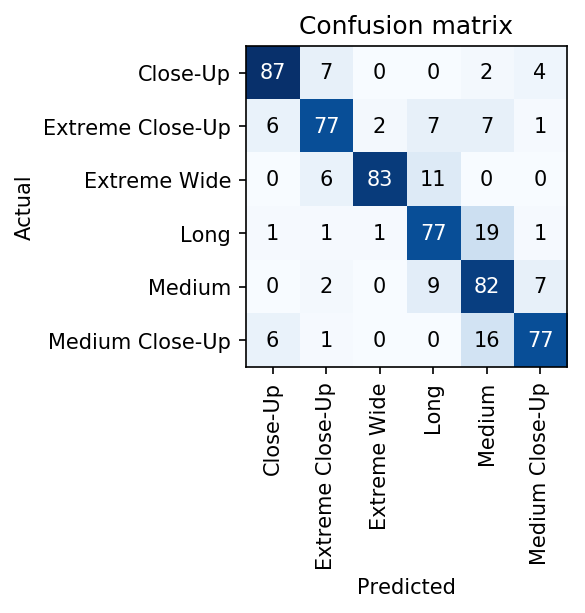

In [ ]:
learn.load('stage-1-1');
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(dpi = 150)

### Fine Tuning                   <a id='stage1-finetune'></a>

In [ ]:
learn.load('stage-1-1');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


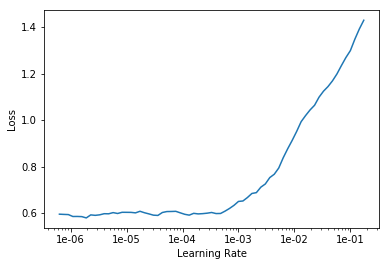

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8, slice(1e-4, 3e-3))

In [ ]:
learn.save('stage-1-2')

### Interpreting                  <a id='stage1-interpret2'></a>

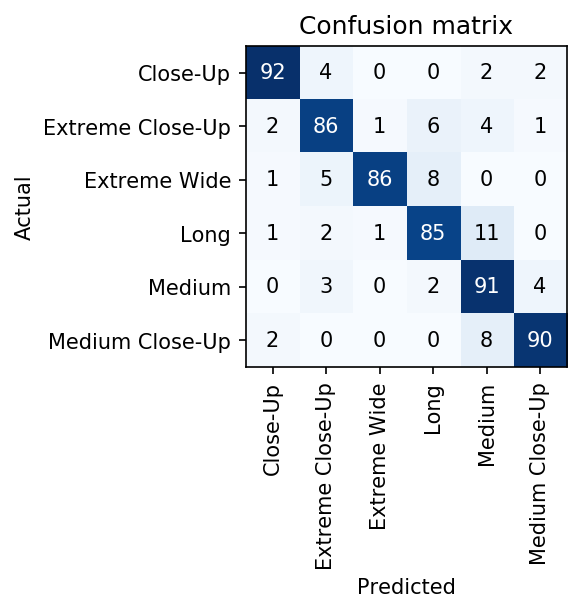

In [ ]:
learn.load('stage-1-2');
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(dpi = 150)

 ----

## Stage 2  <a id='stage2'></a>

### Data Setup                   <a id='stage2-data'></a>

In [ ]:
base_size = 75
base_size = base_size * 3

img_size = to_film_ar(base_size)
tfms = get_tfms()

img_size

(225, 400)

In [ ]:
data = ImageDataBunch.from_folder(path, 'train', 'valid', size = img_size, ds_tfms = tfms, bs=bs,
                                  resize_method = ResizeMethod.SQUISH,
                                  num_workers = 0
                                 ).normalize(imagenet_stats)

In [ ]:
learn.load('stage-1-2')
learn = learn.to_fp16()
learn.freeze()
learn.data = data

### Training                        <a id='stage2-train'></a>

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


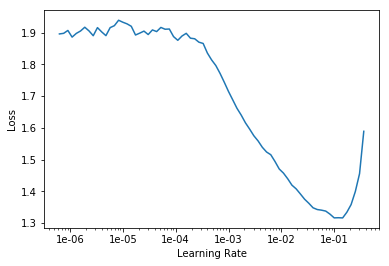

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8, max_lr = slice(2e-3))

In [ ]:
learn.save('stage-2-1')

### Interpreting                  <a id='stage2-interpret1'></a>

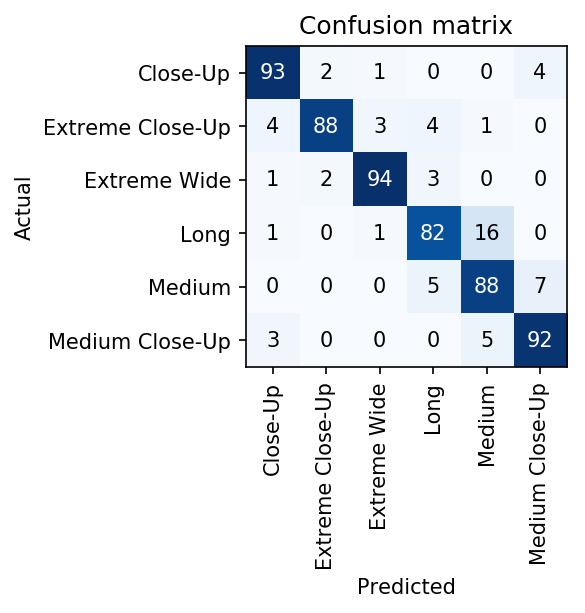

In [ ]:
learn.load('stage-2-1');
learn = learn.to_fp32()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(dpi = 150)

### Fine Tuning                   <a id='stage2-finetune'></a>

In [ ]:
learn.load('stage-2-1');

In [ ]:
learn = learn.to_fp16()
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


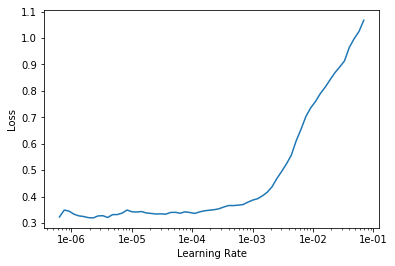

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10, slice(1e-6, 1e-4))

In [ ]:
learn.save('stage-2-2');

### Interpreting                  <a id='stage2-interpret2'></a>

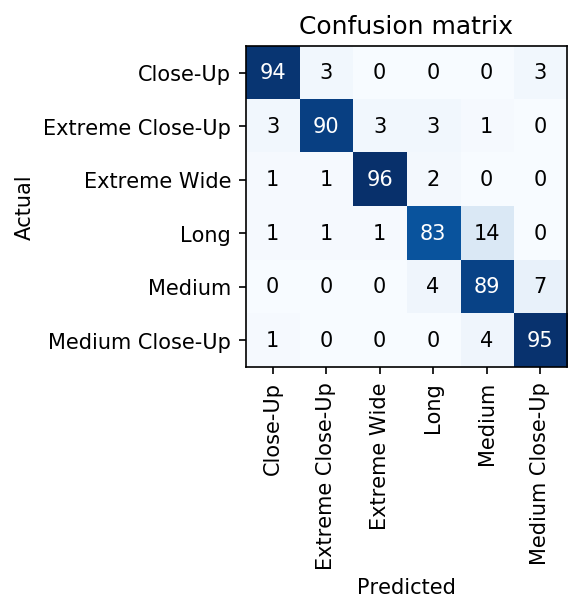

In [ ]:
learn.load('stage-2-2');
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(dpi = 150)

## Stage 3  <a id='stage3'></a>

### Data Setup                    <a id='stage3-data'></a>

In [ ]:
base_size = 75
base_size = base_size * 5
bs=32

img_size = to_film_ar(base_size)
tfms = get_tfms()

img_size

(375, 666)

In [ ]:
data = ImageDataBunch.from_folder(path, 'train', 'valid', size = img_size, ds_tfms = tfms, bs=bs,
                                  resize_method = ResizeMethod.SQUISH,
                                  num_workers = 0
                                 ).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics = [accuracy], pretrained=True)
learn = learn.to_fp16()

In [ ]:
learn.load('stage-2-2');
learn = learn.to_fp16()
learn.freeze()
learn.data = data

### Training                        <a id='stage3-train'></a>

In [ ]:
gc.collect()
torch.cuda.empty_cache()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


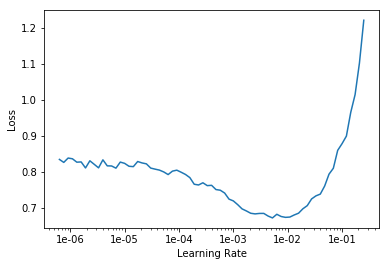

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
learn.fit_one_cycle(8, max_lr = slice(1e-3))

In [ ]:
learn.save('stage-3-1')

### Interpreting                  <a id='stage3-interpret1'></a>

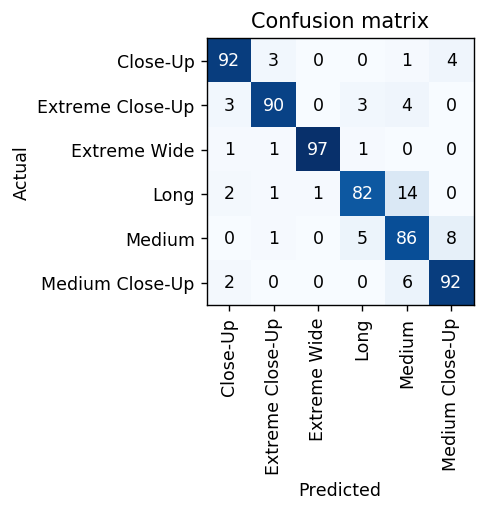

In [ ]:
learn.load('stage-3-1');
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(dpi = 125)

### Fine Tuning <a id='stage3-finetune'></a>

In [ ]:
learn.load('stage-3-1');
learn = learn.to_fp16()

In [ ]:
gc.collect()
torch.cuda.empty_cache()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


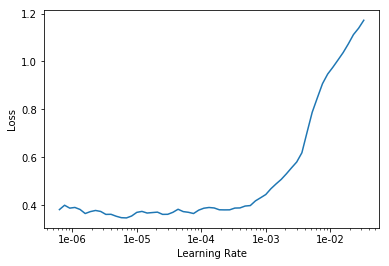

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
learn.fit_one_cycle(10, slice(1e-6, 1e-4))

In [ ]:
learn.save('stage-3-2');

## Interpretation <a id='interpret'></a>

### Confusion Matrix <a id='interpret-conf-mt'></a>

In [ ]:
learn.load('stage-3-2');
learn.data=data

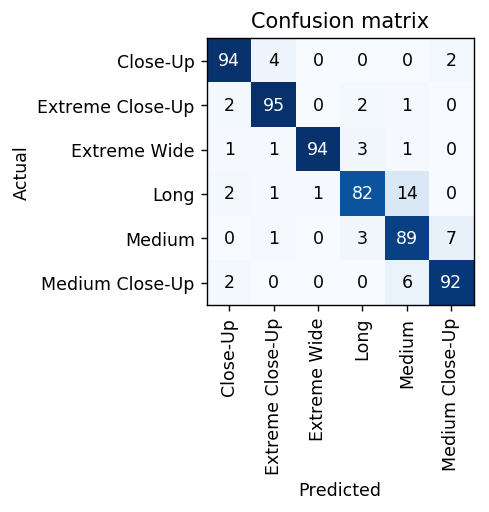

In [ ]:
learn.load('stage-3-2');
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(dpi = 125)

### Top Losses <a id='interpret-top-losses'></a>

This is very useful to improve the model. <br>
I can clearly see that long shots where the subject isn't standing completely almost always fail. <br>
I'll be digging into these in detail to gain a fuller understanding of what the model is capable of.

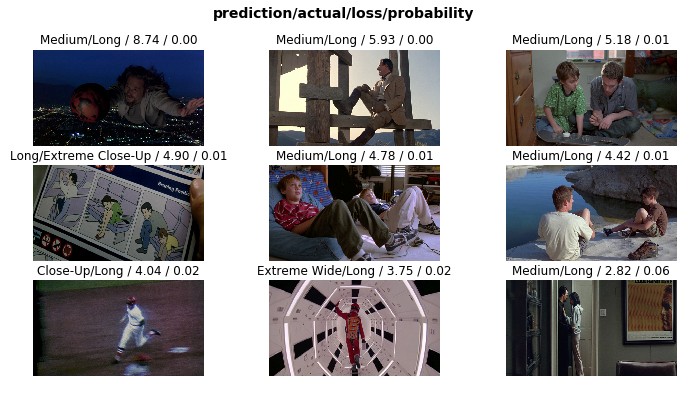

In [ ]:
learn = learn.to_fp32()
interp.plot_top_losses(9, heatmap=False, figsize=(12,6))

## Predicting New Images 

The model does fairly well on animated images too!

In [ ]:
tmp = Path("/home/rahul/Desktop/filmgrab-data/filmgrab-pending/a-scanner-darkly/")
tests = [file for file in tmp.iterdir()]

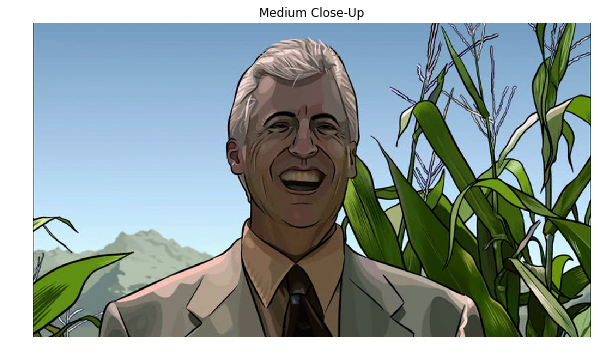

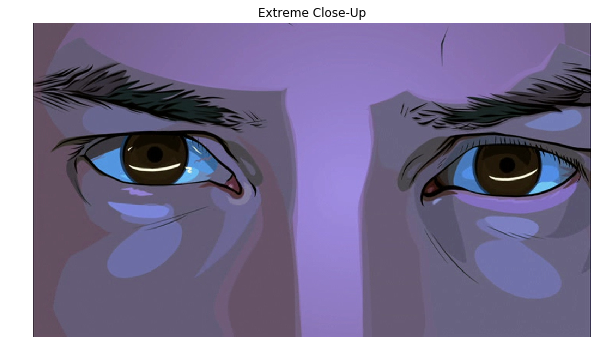

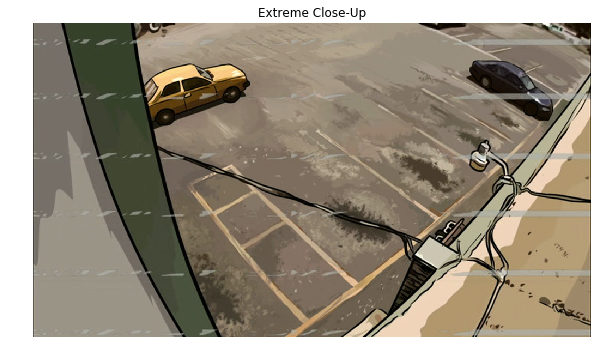

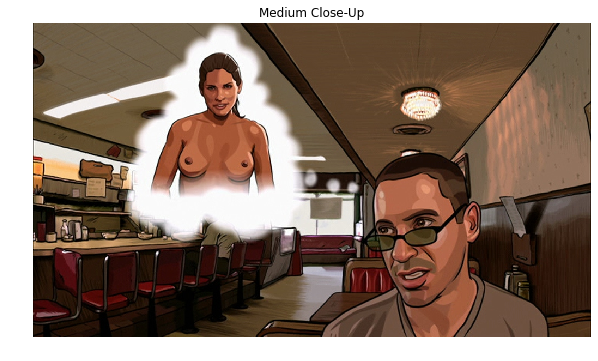

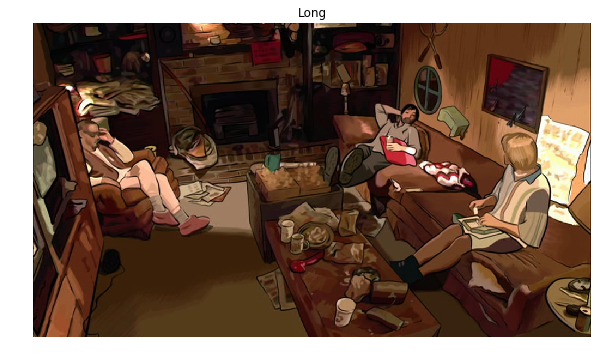

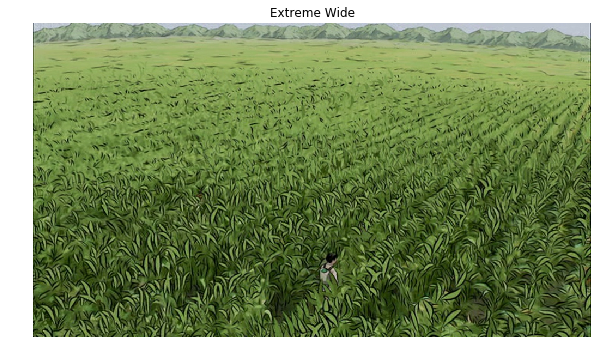

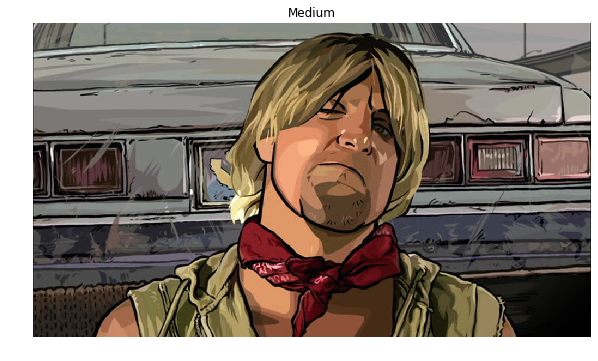

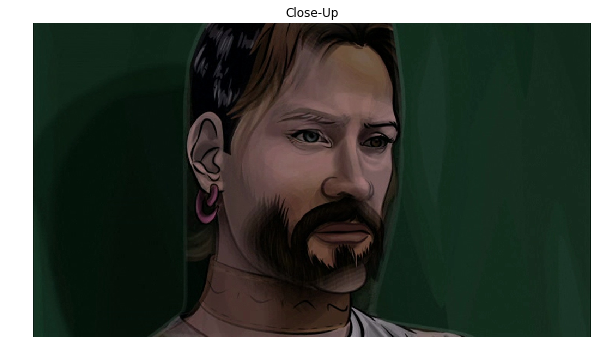

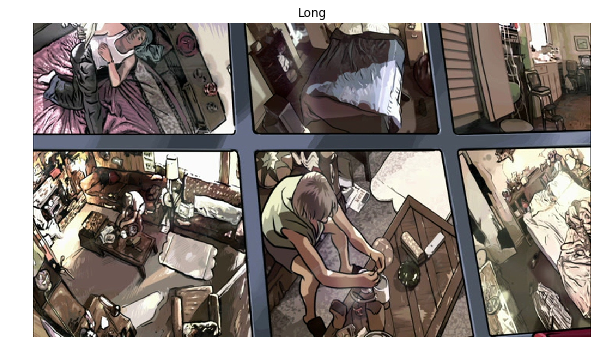

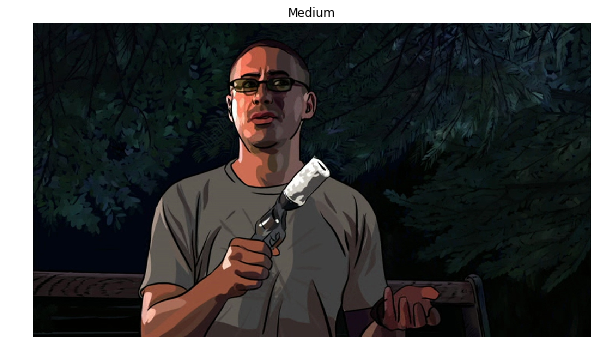

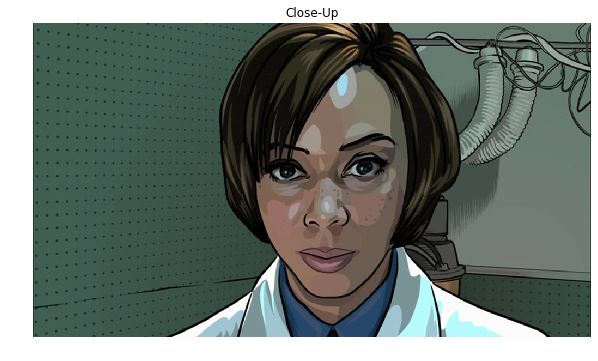

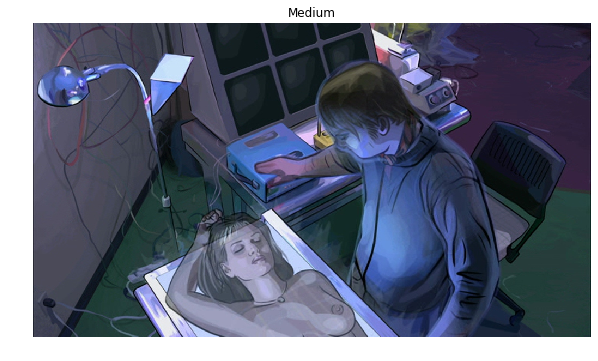

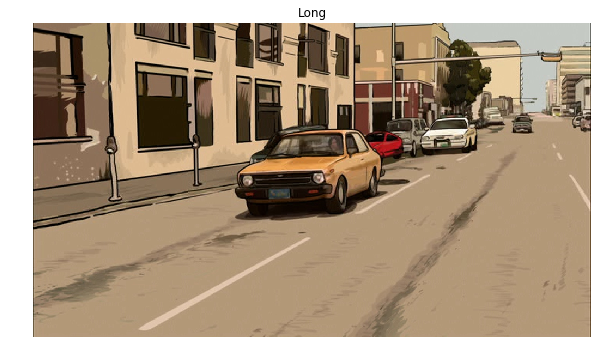

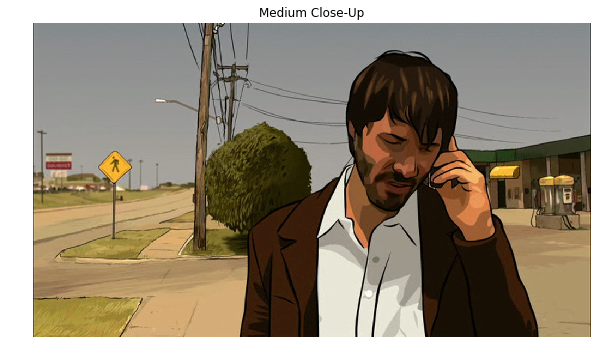

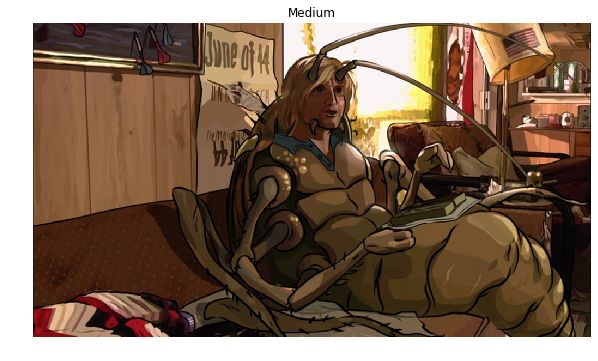

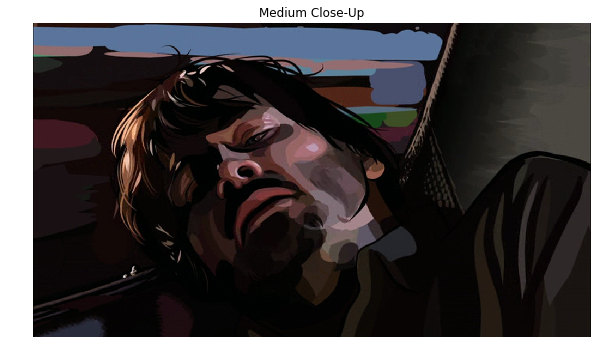

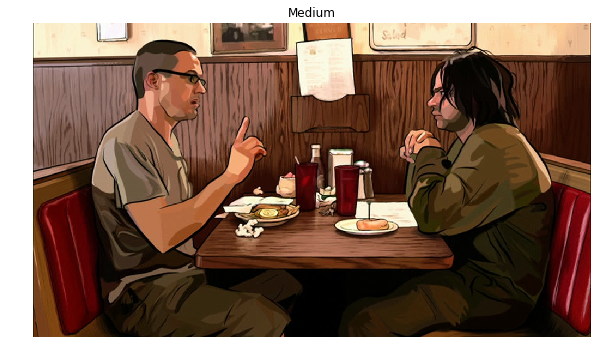

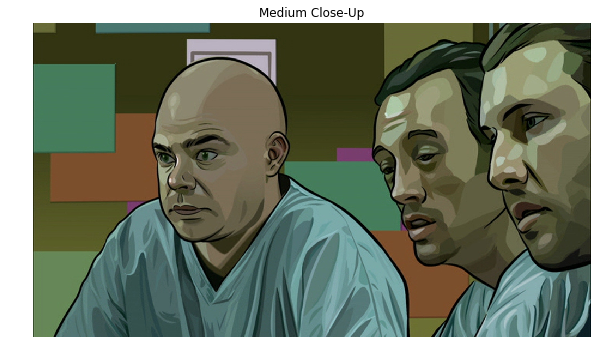

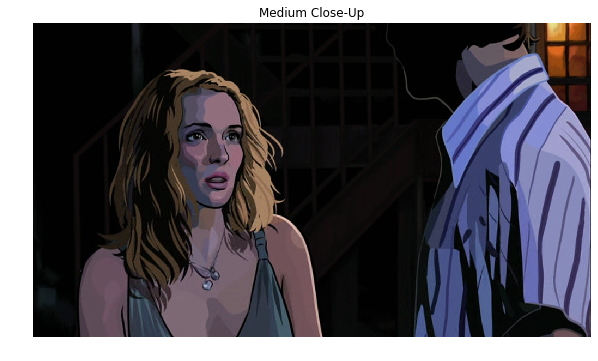

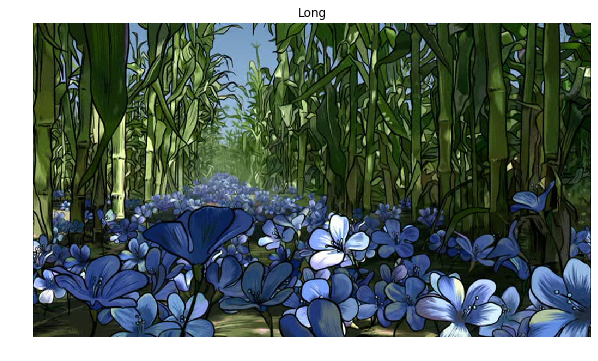

In [ ]:
for file in tests[40:60]:
    img = open_image(file)
    img.show(figsize = (10, 12), title = str(learn.predict(img)[0]))

## fin.